# IPF Performance

The use of iterative proportional fitting (IPF) is quite common on processes
involving doubly-constraining matrices, such as synthetic gravity models and
fractional split models (aggregate destination-choice models).

As this is a commonly used algorithm, we have implemented it in Cython, where
we can take full advantage of multi-core CPUs. We have also implemented the ability
of using both 32-bit and 64-bit floating-point seed matrices, which has direct impact
on cache use and consequently computational performance.

In this section, we compare the
runtime of AequilibraE's current implementation of IPF, 
with a general IPF algorithm written in pure Python, available
[here](https://github.com/joshchea/python-tdm/blob/master/scripts/CalcDistribution.py).

The figure below compares AequilibraE's IPF runtime with one core with the benchmark Python
code. From the figure below, we can notice that the runtimes were practically the same for the
instances with 1,000 zones or less. As the number of zones increases, AequilibraE demonstrated to be slightly faster
than the benchmark python code, while applying IPF to a 32-bit NumPy array (np.float32) was significantly faster.
It's worth mentioning that
the user can set up a threshold for AequilibraE's IPF function, as well as use more than one
core to speed up the fitting process.

![AequilibraE's IPF runtime](../images/ipf_runtime_aequilibrae_vs_benchmark.png)

As IPF is an embarrassingly-parallel workload, it is more relevant to look at the performance of the
AequilibraE implementations, starting by comparing the implementation performance for inputs in 32 vs 64
bits using 32 threads.

![AequilibraE's IPF runtime 32 vs 64 bits](../images/ipf_runtime_32vs64bits.png)

The difference is staggering, with the 32-bit implementation being twice as fast as the 64-bit one for large matrices.
It is also worth noting that differences in results between the outputs between these two versions are incredibly
small (RMSE < 1.1e-10), and therefore unlikely to be relevant in most applications.

We can also look at performance gain across matrix sizes and number of cores, and it becomes clear
that the 32-bit version scales significantly better than its 64-bit counterpart, showing significant performance
gains up to 16 threads, while the latter stops showing much improvement beyond 8 threads, likely due to limitations
on cache size.

![number of cores used in IPF for 64 bit matrices](../images/ipf_runtime_vs_num_cores.png)

![number of cores used in IPF for 32 bit matrices](../images/ipf_runtime_vs_num_cores32bits.png)

In conclusion, AequilibraE's IPF implementation is over 11 times faster than its pure Python counterpart for
large matrices on a workstation, largely due to the use of Cython and multi-threading, but also due to the use of a
32-bit version of the algorithm.

These tests were run on a Threadripper 3970x (released in 2019) workstation with 32 cores (64 threads) @ 3.7 GHz
and 256 Gb of RAM. The code is provided below for reference.

## Reference code

In [1]:
from copy import deepcopy
from time import perf_counter
import numpy as np
import pandas as pd
from aequilibrae.distribution.ipf_core import ipf_core
from tqdm import tqdm

In [2]:
# From:
# https://github.com/joshchea/python-tdm/blob/master/scripts/CalcDistribution.py

def CalcFratar(ProdA, AttrA, Trips1, maxIter=10):
    '''Calculates fratar trip distribution
       ProdA = Production target as array
       AttrA = Attraction target as array
       Trips1 = Seed trip table for fratar
       maxIter (optional) = maximum iterations, default is 10
       Returns fratared trip table
    '''
    # print('Checking production, attraction balancing:')
    sumP = ProdA.sum()
    sumA = AttrA.sum()
    # print('Production: ', sumP)
    # print('Attraction: ', sumA)
    if sumP != sumA:
        # print('Productions and attractions do not balance, attractions will be scaled to productions!')
        AttrA = AttrA*(sumP/sumA)
    else:
        pass
        # print('Production, attraction balancing OK.')
    # Run 2D balancing --->
    for balIter in range(0, maxIter):
        ComputedProductions = Trips1.sum(1)
        ComputedProductions[ComputedProductions == 0] = 1
        OrigFac = (ProdA/ComputedProductions)
        Trips1 = Trips1*OrigFac[:, np.newaxis]

        ComputedAttractions = Trips1.sum(0)
        ComputedAttractions[ComputedAttractions == 0] = 1
        DestFac = (AttrA/ComputedAttractions)
        Trips1 = Trips1*DestFac
    return Trips1

In [3]:
mat_sizes = [500, 750, 1000, 1500, 2500, 5000, 7500, 10000, 15000]

In [4]:
#Benchmarking
bench_data = []
cores = 1
repetitions = 5
iterations = 100
for zones in mat_sizes:
    for repeat in tqdm(range(repetitions), f"Repetitions for zone size {zones}"):
        mat1 = np.random.rand(zones, zones)
        target_prod = np.random.rand(zones)
        target_atra = np.random.rand(zones)
        target_atra *= target_prod.sum()/target_atra.sum()

        aeq_mat = deepcopy(mat1)
        # We use a nonsensical negative tolerance to force it to run all iterations
        # and set warning for non-convergence to false, as we know it won't converge
        t = perf_counter()
        ipf_core(aeq_mat, target_prod, target_atra, max_iterations=iterations, tolerance=-5, cores=cores, warn=False)
        aeqt = perf_counter() - t

        aeq_mat32 = np.array(mat1, np.float32)
        # We now run the same thing with a seed matrix in single-precision (float 32 bits) instead of double as above (64 bits)
        t = perf_counter()
        ipf_core(aeq_mat32, target_prod, target_atra, max_iterations=iterations, tolerance=-5, cores=cores, warn=False)
        aeqt2 = perf_counter() - t
        
        bc_mat = deepcopy(mat1)
        t = perf_counter()
        x = CalcFratar(target_prod, target_atra, bc_mat, maxIter=iterations)

        bench_data.append([zones, perf_counter() - t, aeqt, aeqt2])

Repetitions for zone size 15000: 100%|██████████| 5/5 [32:23<00:00, 388.70s/it]


<Axes: xlabel='Zones in the model'>

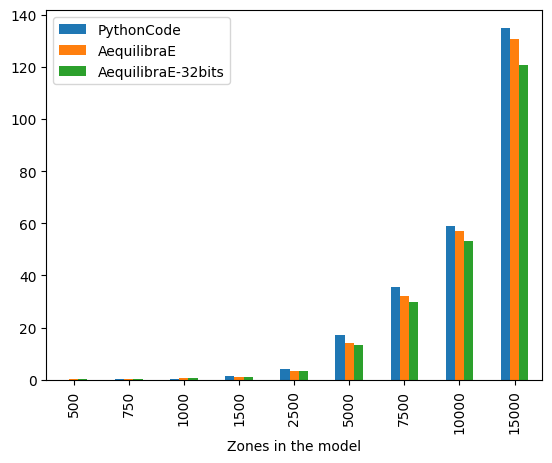

In [5]:
bench_df = pd.DataFrame(bench_data, columns=["Zones in the model", "PythonCode", "AequilibraE", "AequilibraE-32bits"])
bench_df.groupby(["Zones in the model"]).mean().plot.bar()

In [14]:
bench_df.groupby(["Zones in the model"]).mean()

,PythonCode,AequilibraE,AequilibraE-32bits
Zones in the model,,,
500,0.103166,0.140051,0.137266
750,0.241757,0.302931,0.297389
1000,0.513984,0.529727,0.516339
1500,1.416848,1.276844,1.156637
2500,4.253563,3.581645,3.333664
5000,17.059166,14.288760,13.257936
7500,35.568686,32.021563,29.666000
10000,59.030967,57.028204,53.155270
15000,134.895915,130.652199,120.535656


In [16]:
#Benchmarking 32 threads
bench_data_parallel = []
cores = 32
repetitions = 5
iterations = 100
for zones in mat_sizes:
    for repeat in tqdm(range(repetitions), f"Repetitions for zone size {zones}"):
        mat1 = np.random.rand(zones, zones)
        target_prod = np.random.rand(zones)
        target_atra = np.random.rand(zones)
        target_atra *= target_prod.sum()/target_atra.sum()

        aeq_mat = deepcopy(mat1)
        # We use a nonsensical negative tolerance to force it to run all iterations
        # and set warning for non-convergence to false, as we know it won't converge
        t = perf_counter()
        ipf_core(aeq_mat, target_prod, target_atra, max_iterations=iterations, tolerance=-5, cores=cores, warn=False)
        aeqt = perf_counter() - t

        aeq_mat32 = np.array(mat1, np.float32)
        # We now run the same thing with a seed matrix in single-precision (float 32 bits) instead of double as above (64 bits)
        t = perf_counter()
        ipf_core(aeq_mat32, target_prod, target_atra, max_iterations=iterations, tolerance=-5, cores=cores, warn=False)
        aeqt2 = perf_counter() - t
        
        rmse = np.sqrt(np.mean((aeq_mat-aeq_mat32)**2))

        bench_data_parallel.append([zones, aeqt, aeqt2, rmse])

Repetitions for zone size 15000: 100%|██████████| 5/5 [03:10<00:00, 38.02s/it]


<Axes: xlabel='Zones in the model'>

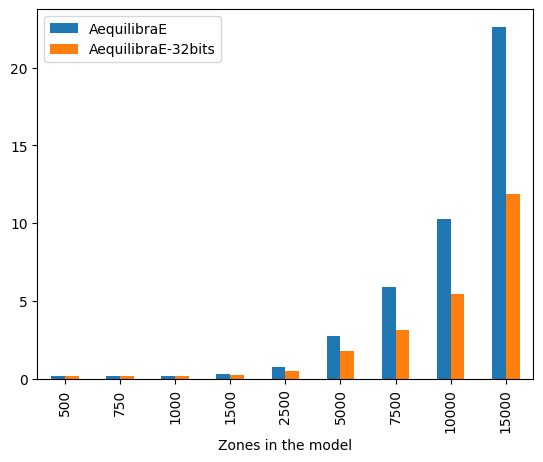

In [17]:
bench_df_parallel = pd.DataFrame(bench_data_parallel, columns=["Zones in the model", "AequilibraE", "AequilibraE-32bits", "rmse"])
bench_df_parallel.groupby(["Zones in the model"]).mean()[[ "AequilibraE", "AequilibraE-32bits"]].plot.bar()

In [18]:
bench_df_parallel.groupby(["Zones in the model"]).mean()

,AequilibraE,AequilibraE-32bits,rmse
Zones in the model,,,
500,0.170232,0.172460,1.080659e-10
750,0.183474,0.183857,7.100473e-11
1000,0.211237,0.191961,5.137420e-11
1500,0.322709,0.252115,3.358886e-11
2500,0.779715,0.522037,2.036197e-11
5000,2.745004,1.760100,9.588117e-12
7500,5.900431,3.170006,6.258958e-12
10000,10.255305,5.456631,4.733115e-12
15000,22.618665,11.860497,3.102268e-12


In [9]:
cores_to_use = [1, 2, 4, 8, 16, 32]

In [10]:
aeq_data = []
repetitions = 1
iterations = 50
for zones in mat_sizes:
    for cores in tqdm(cores_to_use,f"Zone size: {zones}"):
        for repeat in range(repetitions):
            mat1 = np.random.rand(zones, zones)
            target_prod = np.random.rand(zones)
            target_atra = np.random.rand(zones)
            target_atra *= target_prod.sum()/target_atra.sum()

            aeq_mat = np.array(deepcopy(mat1), np.float32)
            t = perf_counter()
            ipf_core(aeq_mat, target_prod, target_atra, max_iterations=iterations, tolerance=-5, cores=cores, warn=False)
            aeqt = perf_counter() - t

            aeq_data.append([zones, cores, aeqt])

Zone size: 15000: 100%|██████████| 6/6 [02:21<00:00, 23.62s/it]


cores,1,2,4,8,16,32
zones,,,,,,
1500,1.0,0.563866,0.426711,0.270452,0.191147,0.213856
2500,1.0,0.527781,0.375033,0.249776,0.156473,0.157657
5000,1.0,0.510183,0.278150,0.174469,0.143175,0.134064
7500,1.0,0.508706,0.265835,0.157217,0.125007,0.107014
10000,1.0,0.507172,0.266192,0.154844,0.120771,0.103968
15000,1.0,0.504696,0.259933,0.152394,0.115052,0.101344


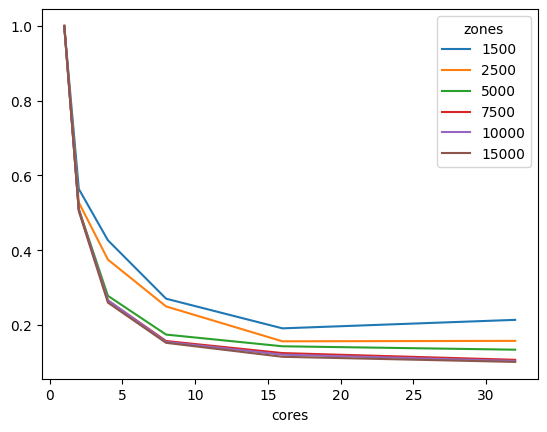

In [19]:
aeq_df = pd.DataFrame(aeq_data, columns=["zones", "cores", "time"])
aeq_df = aeq_df[aeq_df.zones>1000]
aeq_df = aeq_df.groupby(["zones", "cores"]).mean().reset_index()
aeq_df = aeq_df.pivot_table(index="zones", columns="cores", values="time")
for cores in cores_to_use[::-1]:
    aeq_df.loc[:, cores] /= aeq_df[1]
aeq_df.transpose().plot()
aeq_df

In [20]:
aeq_data = []
repetitions = 1
iterations = 50
for zones in mat_sizes:
    for cores in tqdm(cores_to_use,f"Zone size: {zones}"):
        for repeat in range(repetitions):
            mat1 = np.random.rand(zones, zones)
            target_prod = np.random.rand(zones)
            target_atra = np.random.rand(zones)
            target_atra *= target_prod.sum()/target_atra.sum()

            aeq_mat = np.array(deepcopy(mat1), np.float64)
            t = perf_counter()
            ipf_core(aeq_mat, target_prod, target_atra, max_iterations=iterations, tolerance=-5, cores=cores, warn=False)
            aeqt = perf_counter() - t

            aeq_data.append([zones, cores, aeqt])

Zone size: 15000: 100%|██████████| 6/6 [02:47<00:00, 27.93s/it]


cores,1,2,4,8,16,32
zones,,,,,,
1500,1.0,0.559114,0.408111,0.250297,0.216308,0.255603
2500,1.0,0.526490,0.359411,0.255447,0.203943,0.232535
5000,1.0,0.517601,0.311059,0.216065,0.195720,0.187223
7500,1.0,0.528070,0.303304,0.221032,0.200886,0.189343
10000,1.0,0.520901,0.301453,0.209669,0.181450,0.174836
15000,1.0,0.520769,0.307402,0.208882,0.180139,0.176024


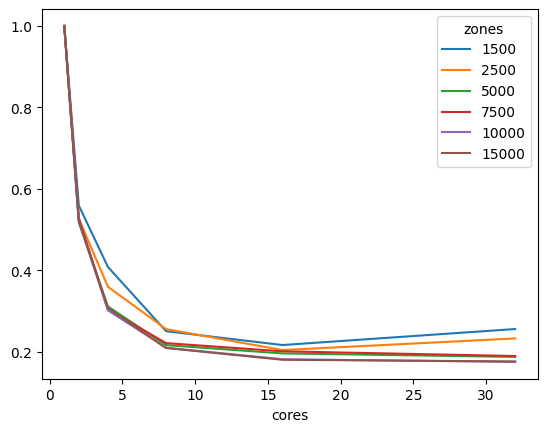

In [21]:
aeq_df = pd.DataFrame(aeq_data, columns=["zones", "cores", "time"])
aeq_df = aeq_df[aeq_df.zones>1000]
aeq_df = aeq_df.groupby(["zones", "cores"]).mean().reset_index()
aeq_df = aeq_df.pivot_table(index="zones", columns="cores", values="time")
for cores in cores_to_use[::-1]:
    aeq_df.loc[:, cores] /= aeq_df[1]
aeq_df.transpose().plot()
aeq_df